<h1>CSE483 Computer Vision Major Task - Phase 2</h1>
<h2>Team 1</h2>
<ul>
<li>Youssef George 19p9824</li>
<li>Kerollos Wageeh 19p3468</li>
<li>Nada Amr 19p1621</li>
</ul>

## Import Libraries
- Use "pip install libName" in terminal if any of them is not installed on your machine.

In [1]:
import numpy as np
import cv2
from scipy.io import loadmat
import json
import statistics
import torch
from torchvision import ops
from operator import itemgetter
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy
import glob
from collections import Counter
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

## Custom Fns

In [2]:
# Fn import pics, labels, true boxes
def getPics(chosen_set):
    images = []
    labels = []
    boxes = []
    
    picsFolder_path = "SVHN/" + chosen_set + "/"
    with open(picsFolder_path + 'digitStruct.json') as f:
        data = json.load(f)
    with open(picsFolder_path + 'phase1Output.json') as f:
        selected_boxes = json.load(f)

# import colored pictures
    for i in range(len(data)):
        image = cv2.imread(picsFolder_path + data[i]['filename'])
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        images.append(image)
        temp=[]
        for j in range(len(data[i]['boxes'])):
            temp.append(data[i]['boxes'][j]['label'])
        temp = np.array(temp)
        labels.append(temp)
        boxes.append(selected_boxes[i]['selected_boxes'+str(i)])

    print("There are ", len(data), " images in " + chosen_set + " set.")
    return images, labels, boxes

In [3]:
def getPicsCropped(chosen_set):
    images = []
    gs_images = []
    labels = []
    boxes = []

    picsFolder_path = "SVHN/" + chosen_set + "_32x32.mat"
    data = scipy.io.loadmat(picsFolder_path)
    images = data['X']
    labels = data['y']
    images = np.array(images)
    images = np.moveaxis(images, -1, 0)
    gs_images = np.array(gs_images)
    gs_images = np.moveaxis(gs_images, -1, 0)
    labels = np.array(labels)
    print(images.shape[0],"cropped images in 32x32 " + chosen_set + " set.")
    return images, labels

In [4]:
train_images_all, train_labels_all = getPicsCropped("train")

73257 cropped images in 32x32 train set.


In [5]:
train_boxes_all[1]

[[100, 28, 121, 57]]

In [6]:
def cropImages(image, boxes):
    img = image.copy()
    img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    cropped = []
    for box in boxes:
        cropped.append(img[box[1]:box[3], box[0]:box[2]])
    return cropped

In [5]:
def getTemplatesPics():
    templates = []
    labels = []
    picsFolder_path = "Matching/"

    srtd_dir = sorted(glob.glob(picsFolder_path + "/*.jpg"))
    # import colored pictures
    for image_path in srtd_dir:
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        template = {'label':int(image_path[9]), 'image':image}
        templates.append(template)
    return templates

In [24]:
def getTemplatesDescriptors():
    templates = getTemplatesPics()
    full_templates = []

    for template in templates:
        sift = cv2.BRISK_create()
        keypoints, descriptors = sift.detectAndCompute(template['image'], None)
        if descriptors is not None:
            template['descriptor']=descriptors
        else:
            template['descriptor']=[]
        full_templates.append(template)
        
    return full_templates

In [25]:
templates = getTemplatesDescriptors()
print(templates[4]['descriptor'])

[]


In [29]:
def predictImage(image):
    mx = 0
    label = -1
    sift = cv2.BRISK_create()
    img_keypoints, img_descriptors = sift.detectAndCompute(image, None)
    for template in templates:
        matcher = cv2.BFMatcher()
        if len(template['descriptor']) > 0:
            matches = matcher.knnMatch(img_descriptors, template['descriptor'], k=2)
            good_matches = []
            if len(matches) > 0:
                if len(matches[0]) == 1:
                    good_matches = matches
                else:
                    for m, n in matches:
                            if m.distance < 0.8 * n.distance:
                                good_matches.append(m)
                acc = len(good_matches) / len(img_keypoints)
                if mx < acc:
                    mx = acc
                    label = template['label']
    return label


In [30]:
def calcPicRecall(trueLabel, predictedLabel):
    if trueLabel == predictedLabel:
        return 1
    else:
        return 0

In [32]:
acc = []
i = 0
for image, label in zip(train_images_all[:10000], train_labels_all[:10000]):
    x = calcPicRecall(label, predictImage(image))
    acc.append(x)
    i+=1
    print(i)
print(np.average(acc))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [23]:
acc = sorted(acc, reverse=True)
print(acc[0:1000])

[array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([

In [10]:
def calcAllRecall(recalls):
    return statistics.mean(recalls)

In [14]:
def predictContour(contour, templates):
    cnt = 0
    acc = 0
    for tmp in templates:
        score = cv2.matchShapes(contour,tmp['contour'],1,0)
        acc +=score
        cnt+=1
        if(cnt==8):
            print(tmp['label'],"avg score",acc/8)
            acc=0
            cnt =0
        

cropped image generated 7 contours
Contour 0
0 avg score 4.215262737698808
1 avg score 3.970107878442423
2 avg score 2.6206715909251495
3 avg score 4.29964742194573
4 avg score 4.046817085172264
5 avg score 4.010059289375141
6 avg score 4.077477753068965
7 avg score 6.15846807791656
8 avg score 4.1266936900674915
9 avg score 4.126603442266975
Contour 1
0 avg score inf
1 avg score inf
2 avg score inf
3 avg score inf
4 avg score inf
5 avg score inf
6 avg score inf
7 avg score inf
8 avg score inf
9 avg score inf
Contour 2
0 avg score 0.023503685888147302
1 avg score 3.109992954094031
2 avg score 2.1295953574116453
3 avg score 2.6625852037439297
4 avg score 0.22826538088188167
5 avg score 2.9491356631717425
6 avg score 0.18126894183624592
7 avg score 5.233389284259254
8 avg score 0.05307079682360222
9 avg score 0.19015454862871328
Contour 3
0 avg score 1.1828382408371367
1 avg score 4.004233652175044
2 avg score 2.2083437977514215
3 avg score 2.7454508238989144
4 avg score 0.91971803802619

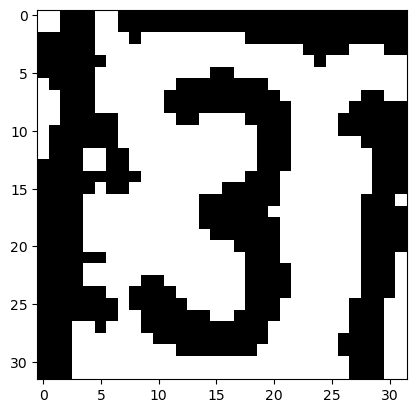

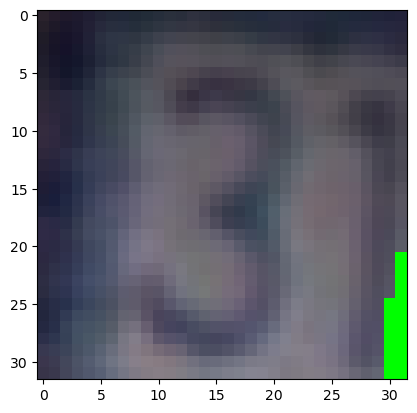

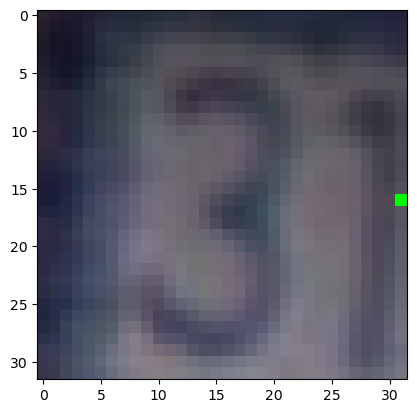

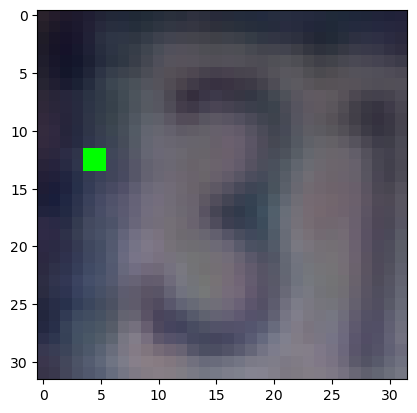

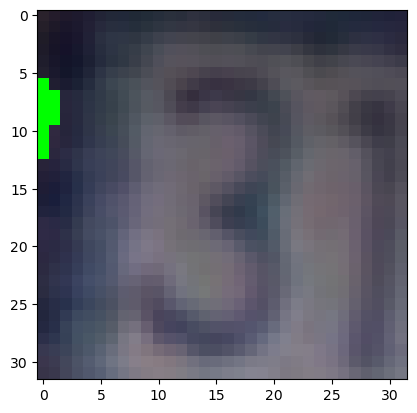

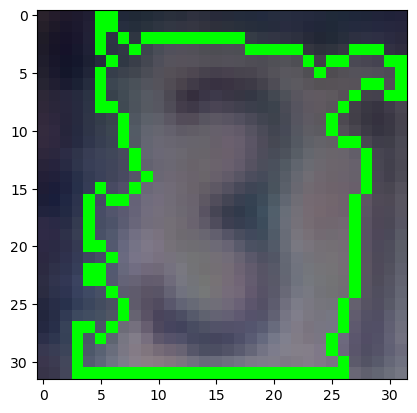

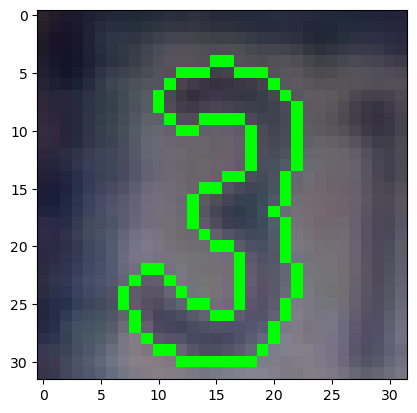

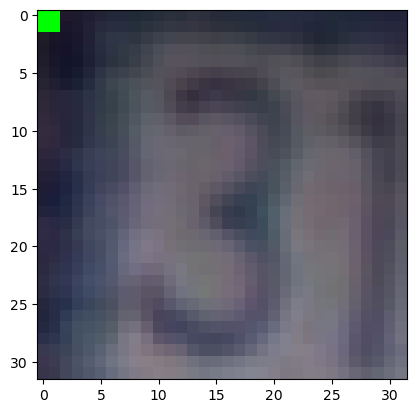

In [15]:
# idx = random.randint(0, len(train_images_all)-1)
idx = 8
trialImage = train_images_cropped_all[idx].copy()
gray = cv2.cvtColor(trialImage, cv2.COLOR_RGB2GRAY)
blurred = cv2.blur(gray,(3,3))
bnr = cv2.adaptiveThreshold(
    blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 1)
contours, hierarchy = cv2.findContours(
    bnr, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
plt.imshow(bnr, cmap='gray')
print("cropped image generated", len(contours), "contours")

i = 0
for cnt in contours:
    print("Contour", i)
    i += 1
    predictContour(cnt, templates)


for j in range(len(contours)):
    tmp = train_images_cropped_all[idx].copy()
    plt.figure()
    toDraw = contours[j]
    cv2.drawContours(image=tmp, contours=[toDraw], contourIdx=-1,
                     color=(0, 255, 0), thickness=1)
    plt.imshow(tmp)
    plt.show()


------------------------------